# Tree detection inference using DeepForest and Detectree2

In [1]:
# Import required libraries
from pathlib import Path
import torch

from tree_detection_framework.constants import DATA_FOLDER
from tree_detection_framework.detection.detector import (
    DeepForestDetector,
    Detectree2Detector,
)
from tree_detection_framework.detection.models import DeepForestModule, Detectree2Module
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define constants
The behavior of this notebook can be changed by adjusting these values.

In [ ]:
# The path to a folder of raster images, e.g. orthomosaics stor
RASTER_FOLDER_PATH = Path(DATA_FOLDER, "emerald-point-ortho")
RASTER_FILE_PATH = Path(RASTER_FOLDER_PATH, "ortho.tif")
# Prediction file path
OUTPUT_PREDICTIONS_FILE_PATH = Path(
    DATA_FOLDER, "emerald-point-ortho-detectree2-predictions.gpkg"
)
# The size of the chips in pixels
CHIP_SIZE = 1024
# The stride between chips in pixels
CHIP_STRIDE = 768
# The spatial resolution that the data is sampled to in meters/pix
RESOLUTION = 0.05
# The number of samples in a batch
BATCH_SIZE = 4
# Any detections below this threshold will be discarded
MIN_CONFIDENCE_THRESHOLD = 0.3
# Detections that overlap more than this threshold will be suppressed
IOU_NMS_THESHOLD = 0.3

# How many tiles to show
N_VIS_TILES = 3

# Choose the tree detction model you want to use from: "deepforest" and "detectree2"
TREE_DETECTOR = "detectree2"

# Setup the parameters dictionary use DeepForest
DEEPFOREST_MODEL_PARAMS = {
    "backbone": "retinanet",
    "num_classes": 1,
}
# Setup the parameters dictionary use Detectree2
DETECTREE2_MODEL_PARAMS = {
    "update_model": "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"
}
# The device to use for inference, GPU or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Create a dataloader to generate samples

In [ ]:
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    resolution=RESOLUTION,
    batch_size=BATCH_SIZE,
)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 768


Show example samples

/ofo-share/repos-amritha/conda/envs/sam-tdf/lib/python3.10/site-packages/rasterio/merge.py:483: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  data = src.read(


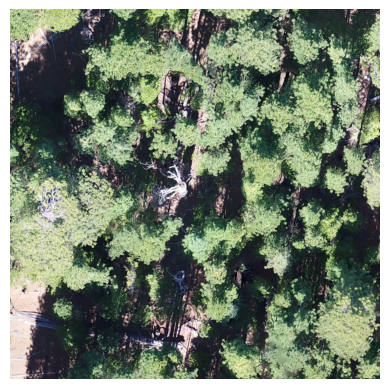

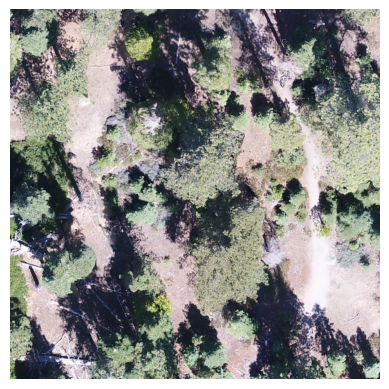

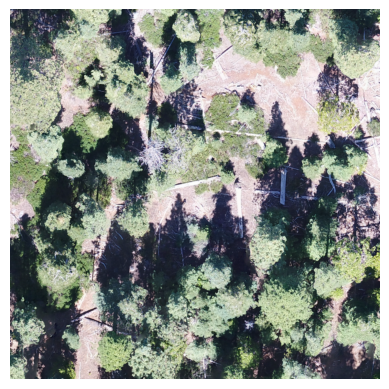

In [4]:
visualize_dataloader(dataloader, n_tiles=N_VIS_TILES)

Create a DeepForest or Detectree2 detector model

In [ ]:
# Create the module and detector based on the TREE_DETECTOR selected
if TREE_DETECTOR == "deepforest":

    # This model uses pretrained weights from DeepForest
    module = DeepForestModule(DEEPFOREST_MODEL_PARAMS).to(DEVICE)
    detector = DeepForestDetector(module)

elif TREE_DETECTOR == "detectree2":

    # This model uses pretrained weights from Detectree2
    module = Detectree2Module(DETECTREE2_MODEL_PARAMS)
    detector = Detectree2Detector(module)

INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...


Generate predictions for each tile in the dataloader

In [ ]:
outputs = detector.predict(dataloader)

Plot the predictions for all overlapping tiles colored by the prediction confidence

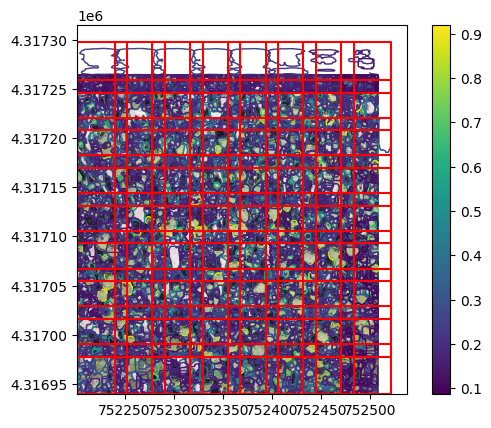

<Axes: >

In [6]:
outputs.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

Show the prediction of just one tile without the raster

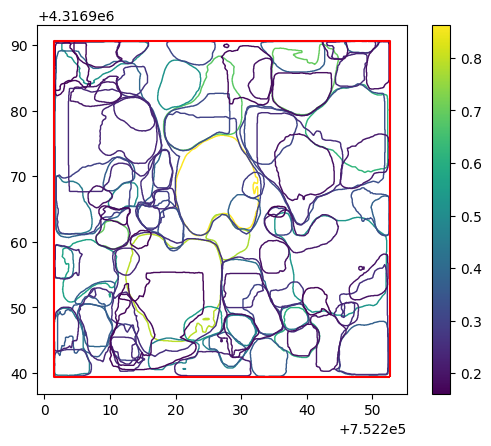

In [7]:
outputs.region_detections[0].plot(visualization_column="score", bounds_color="r")

Run nonmax suppression and across all the tiles and remove low-confidence detections

In [ ]:
NMS_outputs = multi_region_NMS(
    outputs,
    confidence_column="score",
    threshold=IOU_NMS_THESHOLD,
    min_confidence=MIN_CONFIDENCE_THRESHOLD,
)

/ofo-share/repos-david/conda/envs/tree-detection-framework3/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-12-11 21:44:39,602 - INFO - Bound have overlap, running across-region NMS
/ofo-share/repos-david/conda/envs/tree-detection-framework3/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Show the result again after running NMS

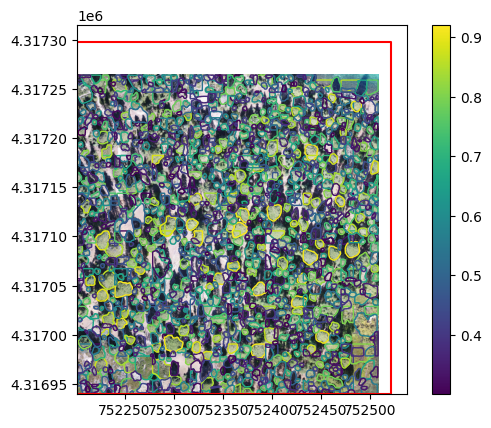

In [10]:
NMS_outputs.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

Save out the predictions to a geospatial file

In [11]:
NMS_outputs.save(OUTPUT_PREDICTIONS_FILE_PATH)

2024-12-11 21:45:53,625 - INFO - Created 1,418 records
